In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#!pip3 install -U git+https://github.com/PYFTS/pyFTS
#!pip3 install SimpSOM
from keras.models import Model
from keras.layers import Dense, Input
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from pyFTS.benchmarks import Measures
import statistics
from pyFTS.common.Util import persist_obj, load_obj
from pyFTS.models.multivariate import common, variable, wmvfts
from pyFTS.partitioners import Grid
from pyFTS.common import Membership
import math
import pyFTS
import datetime
from pyFTS.common import Util

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
df = pd.read_csv('energydata_complete.csv')
df.pop('date')
df.pop('rv1')
df.pop('rv2')

0        13.275433
1        18.606195
2        28.642668
3        45.410389
4        10.084097
           ...    
19730    43.096812
19731    49.282940
19732    29.199117
19733     6.322784
19734    34.118851
Name: rv2, Length: 19735, dtype: float64

In [71]:
def forecast_reducted(train, test, epochs):
    Y = train['Appliances'].reset_index()
    Y2 = test['Appliances'].reset_index()
    Y.pop('index')
    Y2.pop('index')
    test.pop('Appliances')
    train.pop('Appliances')
    
    input_layer = Input(shape=(25, ))
    encoder_layer_1 = Dense(12, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoder_layer_2 = Dense(2, activation="tanh")(encoder_layer_1)

    decoder_layer_1 = Dense(12, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(encoder_layer_2)
    decoder_layer_2 = Dense(25, activation="tanh")(decoder_layer_1)

    autoencoder = Model(input_layer, decoder_layer_2)
    autoencoder.compile(optimizer = 'adam', loss='mse')
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(train)
    X_test = scaler.fit_transform(test)
    autoencoder.fit(x=X_train, y=X_train, epochs=epochs)

    encoder = Model(inputs=input_layer, outputs=encoder_layer_2)

    encoded_train = pd.DataFrame(encoder.predict(X_train))
    encoded_train.columns = ['factor_1', 'factor_2']
    encoded_train = encoded_train.join(Y)
    
    encoded_test = pd.DataFrame(encoder.predict(X_test))
    encoded_test.columns = ['factor_1', 'factor_2']
    encoded_test = encoded_test.join(Y2)
    

    VX1= variable.Variable("factor_1", data_label="factor_1", partitioner = Grid.GridPartitioner, npart=50,     data=encoded_train )
    VX2= variable.Variable("factor_2", data_label="factor_2", partitioner = Grid.GridPartitioner, npart=50,     data=encoded_train )
    VY = variable.Variable("Appliances", data_label="Appliances", partitioner   = Grid.GridPartitioner, npart=50,   data=encoded_train ) 

    model = pyFTS.models.multivariate.wmvfts.WeightedMVFTS(explanatory_variables=[VX1, VX2, VY], target_variable=VY)
    model.fit(encoded_train)
    forecasts = model.predict(encoded_test)



    return forecasts


In [72]:
forecasts = []
appliances = []
result = {
     "window": [],
     "rmse": [],
     "mape": [],
     "smape": []
}

tam = len(df)
n_windows = 10
windows_length = math.floor(tam / n_windows)
for ct, ttrain, ttest in Util.sliding_window(df, windows_length, 0.75, inc=1):
    if len(ttest) > 0:
        appliance = ttest['Appliances'].reset_index()
        print('-' * 20)
        print(f'training window {(ct)}')
        forecast = forecast_reducted(ttrain, ttest, 50)
        
        print("[{0: %H:%M:%S}]".format(datetime.datetime.now()) + f" getting statistics")
        appliance.pop('index')
        rmse = Measures.rmse(appliance.values,forecast)
        mape = Measures.mape(appliance.values,forecast)
        smape = Measures.smape(appliance.values,forecast)
        
        forecasts.append(forecast)
        appliances.append(appliance)
        
        result["rmse"].append(rmse)
        result["mape"].append(mape)
        result["smape"].append(smape)
        result["window"].append(ct)

measures = pd.DataFrame(result)



     index  Appliances
0     1480          40
1     1481          50
2     1482          40
3     1483          40
4     1484          40
..     ...         ...
488   1968          50
489   1969          20
490   1970          40
491   1971          30
492   1972          50

[493 rows x 2 columns]
--------------------
training window 0
Epoch 1/50
47/47 [==============================] - 0s 629us/step - loss: 0.2747
Epoch 2/50
47/47 [==============================] - 0s 620us/step - loss: 0.1393
Epoch 3/50
47/47 [==============================] - 0s 666us/step - loss: 0.0694
Epoch 4/50
47/47 [==============================] - 0s 829us/step - loss: 0.0496
Epoch 5/50
47/47 [==============================] - 0s 765us/step - loss: 0.0452
Epoch 6/50
47/47 [==============================] - 0s 784us/step - loss: 0.0420
Epoch 7/50
47/47 [==============================] - 0s 619us/step - loss: 0.0399
Epoch 8/50
47/47 [==============================] - 0s 602us/step - loss: 0.0367
Epoch 9/50
47

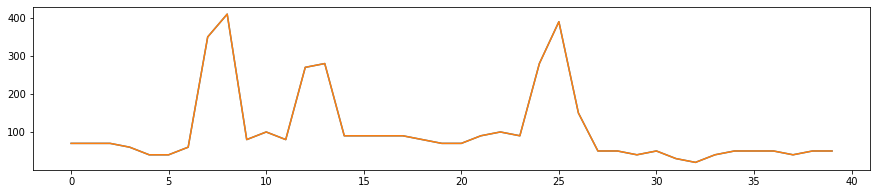

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])
plt.plot(appliances[0][400:440].values)
plt.plot(forecasts[0][400:440])

In [68]:
Measures.rmse(appliances[0][400:440].values,forecasts[0][400:440])

140.77952621031227

In [73]:
measures

,window,rmse,mape,smape
0,0,160.090498,135.712646,35.085827
1,1973,108.199884,87.671610,28.201356
2,3946,148.347177,118.795165,33.544252
3,5919,123.597367,96.796070,29.409907
4,7892,112.260276,85.038135,27.665200
5,9865,75.365070,63.040700,22.301928
6,11838,151.737543,92.017285,28.690125
7,13811,121.918805,81.701195,26.402189
8,15784,137.639033,79.220221,25.730821
9,17757,160.124002,93.052725,29.876681


In [74]:
print("Mean: ")
print(statistics.mean(measures['rmse']))
print(statistics.mean(measures['mape']))
print(statistics.mean(measures['smape']))

Mean: 
129.92796538327474
93.30457523714101
28.69082856053129
